# Cluster analysis around the Herbig AeBe star HD 200775

This use case is based on work by [Pérez Blanco+ 2019](https://ui.adsabs.harvard.edu/abs/2019gaia.confE..19P/abstract). 

Follow the instructions [here](https://github.com/esdc-esac-esa-int/pyesasky/blob/master/README.md) to install the pyESASky widget. More information can be found [here](https://www.cosmos.esa.int/web/esdc/pyESASky).

Workflow:
1. Query the [Vioque+ 2018](https://ui.adsabs.harvard.edu/abs/2018A%26A...620A.128V/abstract) catalogue of Herbig Ae/Be stars to obtain the stellar parameters, using the VizieR astroquery module.
2. Query the Gaia archive for sources around HD 200775 and identify possible cluster candidates by filtering on proper motions and quality, using the Gaia astroquery module.
3. Query the Herschel archive and download a PACS image of the region, using the ESASky astroquery module.
4. Overlay the Gaia results on the Herschel image.
5. Visualise the results in the pyESASky widget.

In [1]:
# Import all the required python modules:
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from astroquery.vizier import Vizier
from astroquery.gaia import Gaia
from astroquery.esasky import ESASky
from astropy.wcs import WCS
from astropy.visualization import (MinMaxInterval, SqrtStretch, ImageNormalize, ManualInterval)
from pyesasky.pyesasky import ESASkyWidget
from pyesasky.catalogue import Catalogue
from pyesasky.catalogueDescriptor import CatalogueDescriptor
from pyesasky.metadataDescriptor import MetadataDescriptor
from pyesasky.metadataType import MetadataType
from pyesasky.cooFrame import CooFrame

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')

### Step 1. Query VizieR 

In [3]:
# Search for 'Gaia DR2 study of Herbig Ae/Be stars (Vioque+, 2018)':
catalog_list = Vizier.find_catalogs('Vioque+, 2018')
print({k:v.description for k,v in catalog_list.items()})

{'J/A+A/620/A128': 'Gaia DR2 study of Herbig Ae/Be stars (Vioque+, 2018)'}


In [4]:
# Get the above list of catalogues:
Vizier.ROW_LIMIT = -1
catalogs = Vizier.get_catalogs(catalog_list.keys())
print(catalogs)

TableList with 3 tables:
	'0:J/A+A/620/A128/hqsample' with 29 column(s) and 218 row(s) 
	'1:J/A+A/620/A128/lqsample' with 29 column(s) and 34 row(s) 
	'2:J/A+A/620/A128/refs' with 4 column(s) and 69 row(s) 


In [5]:
# Access the first table: 
Vioque = catalogs['J/A+A/620/A128/hqsample']
print(Vioque[54])

   Name     RAICRS     DEICRS     plx     Dist   Teff  LogL    Av     V   Bin   E_NIR_     E_MIR_     EWHa   Hashape   Vi  UXOR  Mass     Age      E_J_  E_H_   E_Ks_   E_W1_  E_W2_   E_W3_     E_W4_    The SimbadName  _RA.icrs   _DE.icrs
           "h:m:s"    "d:m:s"     mas      pc     K   [Lsun]  mag    mag                             0.1 nm                      Msun     Myr                                                                             "h:m:s"    "d:m:s" 
--------- ---------- --------- --------- ------ ----- ------ ------ ----- --- ---------- ---------- -------- ------- ----- ---- ------ ---------- ----- ------ ------- ------- ----- --------- ---------- --- ---------- ---------- ---------
HD 200775 21 01 36.9 +68 09 48  2.770664  360.8 16500   3.07  1.054  7.33 Yes     0.0413     0.0388  -63.830       d  0.07       5.345   4.14e+05  2.25   3.98    8.36   25.21    --    149.52    2914.79 Yes  HD 200775 21 01 36.9 +68 09 48


### Step 2. Query the Gaia archive

The following performs an asynchronous query (asynchronous rather than synchronous queries should be performed when retrieving more than 2000 rows) using the Astronomical Data Query Language (ADQL) on the Gaia DR2 catalogue for sources within a search radius of 0.2 degrees around the Herbig Ae/Be star, firstly with no quality filtering on the catalogue.

See [here](https://gea.esac.esa.int/archive-help/adql/examples/index.html) for more information and examples of ADQL queries. 

In [6]:
tables = Gaia.load_tables(only_names=True)
# Do the following to load and look at the available Gaia table names:
#for table in (tables):
#    print (table.get_qualified_name())

Retrieving tables...
Parsing tables...
Done.


In [7]:
tables = Gaia.load_tables(only_names=True)

job = Gaia.launch_job_async("SELECT * FROM gaiadr2.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',315.40383,68.16327,0.2))=1 \
;", dump_to_file=False)

Retrieving tables...
Parsing tables...
Done.
Query finished.


In [8]:
g = job.get_results()
print (g['source_id', 'pmra', 'pmdec', 'parallax'])

     source_id              pmra                pmdec              parallax     
                         mas.yr**-1           mas.yr**-1             mas        
------------------- -------------------- ------------------- -------------------
2270057586519184000   -3.314622581114413  -4.281743275298246  0.6314800879434188
2270055898595769472    6.182300130469731 -1.3647752099072872  0.8524556736136708
2270050783290988544   -3.353645274649903  0.5101568552371537  0.5879406173492704
2270057689598399360    7.770011898936287 -1.4279546209333012  2.9612467088659393
2270057723958137600    8.311545713476313 -1.1525369764318092  2.9783726157791746
2270050405333867776   -4.653376260701559  -1.261989667505687  0.6022991620808252
2270051161248111616   -2.649757093788174 -0.6502715131143503  0.4682234132151094
2270049889937792128   -7.086115159247534  -3.383802393250095  1.0452762970385412
2270057414720493440   3.2674991560117506  -9.943934070024795  0.9118536565314175
2270055142681493120   -2.877

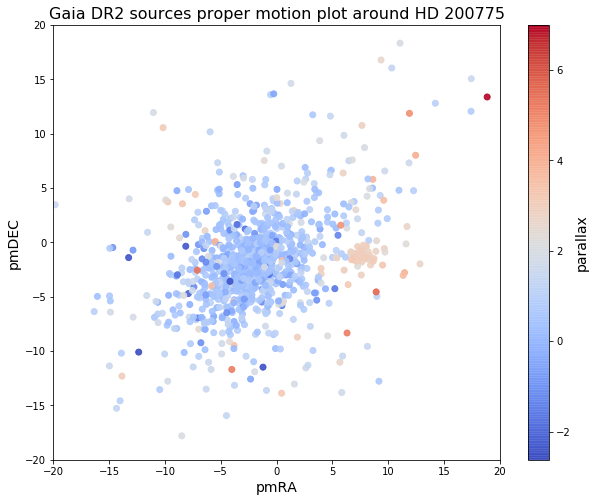

In [9]:
# Plot the results in a proper motion plot of proper motion in RA (pmra) versus proper motion in DEC (pmdec) 
# in the range pmra [-20,20] and pmdec [-20,20]
plt.figure(figsize=(10, 8))
graph = plt.scatter(g['pmra'], g['pmdec'], alpha=0.9, c=g['parallax'], cmap=plt.cm.coolwarm)
cb = plt.colorbar(graph)
cb.set_label('parallax',fontsize=14)
#plt.scatter(g['pmra'], g['pmdec'],color='r',alpha=0.3)
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.title('Gaia DR2 sources proper motion plot around HD 200775',fontsize=16)
plt.xlabel(r'pmRA',fontsize=14)
plt.ylabel(r'pmDEC',fontsize=14)

plt.show()

In [10]:
# Retrieve the Gaia parameters parallax, pmra and pmdec for HD 200775. From Vioque+ 2018 we know that 
# parallax = 2.770664
job2 = Gaia.launch_job_async("SELECT ra, dec, parallax, pmra, pmdec FROM gaiadr2.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',315.40383,68.16327,0.2))=1 \
AND parallax BETWEEN 2.770660 AND 2.770670 ;", dump_to_file=False)
                             
r = job2.get_results()
print (r['dec', 'parallax', 'pmra', 'pmdec'])

Query finished.
       dec             parallax            pmra              pmdec       
       deg               mas            mas.yr**-1         mas.yr**-1    
----------------- ----------------- ----------------- -------------------
68.16326271415059 2.770663848935632 8.335537486577103 -1.5655783707565698


In [11]:
# Run a second asynchronous query on the Gaia archive, filtering the results by quality, proper motion and parallax:
job3 = Gaia.launch_job_async("SELECT * FROM gaiadr2.gaia_source as gaia \
INNER JOIN gaiadr2.ruwe \
ON gaia.source_id = gaiadr2.ruwe.source_id \
WHERE CONTAINS(POINT('ICRS',gaia.ra,gaia.dec),CIRCLE('ICRS',315.40383,68.16327,0.2))=1 \
AND gaia.phot_g_mean_mag < 19 \
AND gaia.parallax_over_error > 10 \
AND gaia.phot_g_mean_flux_over_error > 50 \
AND gaia.visibility_periods_used > 8 \
AND gaiadr2.ruwe.ruwe < 1.4 \
AND gaia.parallax BETWEEN 2 AND 3.5 \
AND gaia.pmra BETWEEN 5 AND 11 \
AND gaia.pmdec BETWEEN -4 AND 1;", dump_to_file=False)

candidates = job3.get_results() 
len(candidates)

Query finished.


23

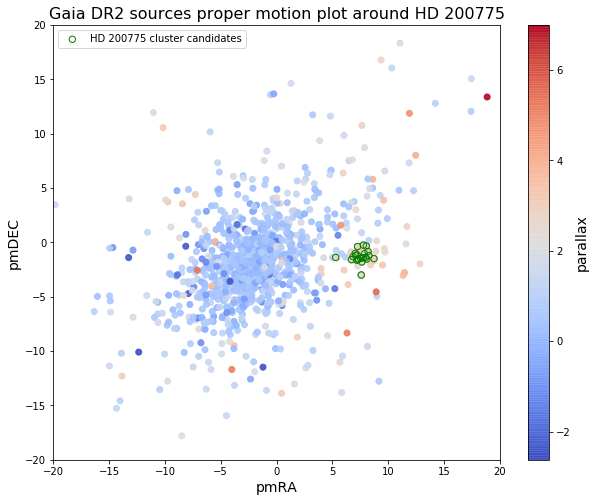

In [12]:
plt.figure(figsize=(10, 8))
plt.scatter(candidates['pmra'], candidates['pmdec'], s=40, edgecolor='g', facecolor='none')
graph = plt.scatter(g['pmra'], g['pmdec'], alpha=0.9, c=g['parallax'], cmap=plt.cm.coolwarm)
cb = plt.colorbar(graph)
cb.set_label('parallax',fontsize=14)
plt.scatter(candidates['pmra'], candidates['pmdec'], s=40, edgecolor='g', facecolor='none')
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.title('Gaia DR2 sources proper motion plot around HD 200775',fontsize=16)
plt.xlabel(r'pmRA',fontsize=14)
plt.ylabel(r'pmDEC',fontsize=14)
plt.legend(["HD 200775 cluster candidates"])

plt.show()

### Step 3. Query the Herschel archive

In [13]:
# Query ESASky for the available Herschel maps
maps = ESASky.query_object_maps('HD 200775',['HERSCHEL'])
print (maps)

TableList with 1 tables:
	'0:HERSCHEL' with 12 column(s) and 9 row(s) 


In [14]:
# Inspect the table 
maps['HERSCHEL'].info

<Table masked=True length=9>
      name       dtype  format
--------------- ------- ------
   postcard_url  object       
    product_url  object       
 observation_id  object       
observation_oid   int32       
         ra_deg float64 {!r:>}
        dec_deg float64 {!r:>}
    target_name  object       
     instrument  object       
         filter  object       
     start_time  object       
       duration float64 {!r:>}
          stc_s  object       

In [15]:
# Inspect the columns
maps['HERSCHEL']['observation_id', 'instrument', 'filter'].pprint()

observation_id instrument     filter   
-------------- ---------- -------------
    1342187078       PACS       70, 160
    1342183680      SPIRE 250, 350, 500
    1342197676       PACS      100, 160
    1342188653      SPIRE 250, 350, 500
    1342188652      SPIRE 250, 350, 500
    1342188653       PACS       70, 160
    1342187077       PACS       70, 160
    1342197675       PACS      100, 160
    1342188652       PACS       70, 160


In [16]:
# Download the images
maps_data = ESASky.get_maps(maps,'HERSCHEL')  

Starting download of HERSCHEL data. (9 files)
INFO: Maps available at /Users/dbaines/LinuxPC/Python/Access_to_Archives/STARRY/Maps [astroquery.esasky.core]


In [17]:
# Inspection of the Herschel PACS 70um header
her_hdu = maps_data["HERSCHEL"][0]["70"]
her_hdu.info()
her_hdu[0].header

Filename: Maps/HERSCHEL/anonymous1559311948/hpacs_25HPPJSMAPB_blue_2102_p6809_00_v1.0_1470433023076.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     284   ()      
  1  image         1 ImageHDU        52   (653, 706)   float64   
  2  coverage      1 ImageHDU        55   (653, 706)   float64   
  3  stDev         1 ImageHDU        55   (653, 706)   float64   
  4  History       1 ImageHDU        23   ()      
  5  HistoryScript    1 BinTableHDU     39   81R x 1C   [321A]   
  6  HistoryTasks    1 BinTableHDU     46   55R x 4C   [1K, 38A, 1K, 9A]   
  7  HistoryParameters    1 BinTableHDU     74   507R x 10C   [1K, 21A, 7A, 31A, 1L, 1K, 1L, 58A, 11A, 35A]   


SIMPLE  =                    T / Java FITS: Fri Aug 05 21:24:38 CEST 2016       
BITPIX  =                   32                                                  
NAXIS   =                    0 / Dimensionality                                 
EXTEND  =                    T / May contain datasets                           
TIMESYS = 'UTC     '           / All dates are in UTC time                      
LONGSTRN= 'OGIP 1.0'           / The OGIP long string convention may be used.   
COMMENT This FITS file may contain long string keyword values that are          
COMMENT continued over multiple keywords.  This convention uses the  '&'        
COMMENT character at the end of a string which is then continued                
COMMENT on subsequent keywords whose name = 'CONTINUE'.                         
          ---------------Herschel FITS Data Generator---------------            
          This product is generated by Herschel software.                       
HCSS____=                   

### Step 4. Overlay the Gaia sources on the Herschel image

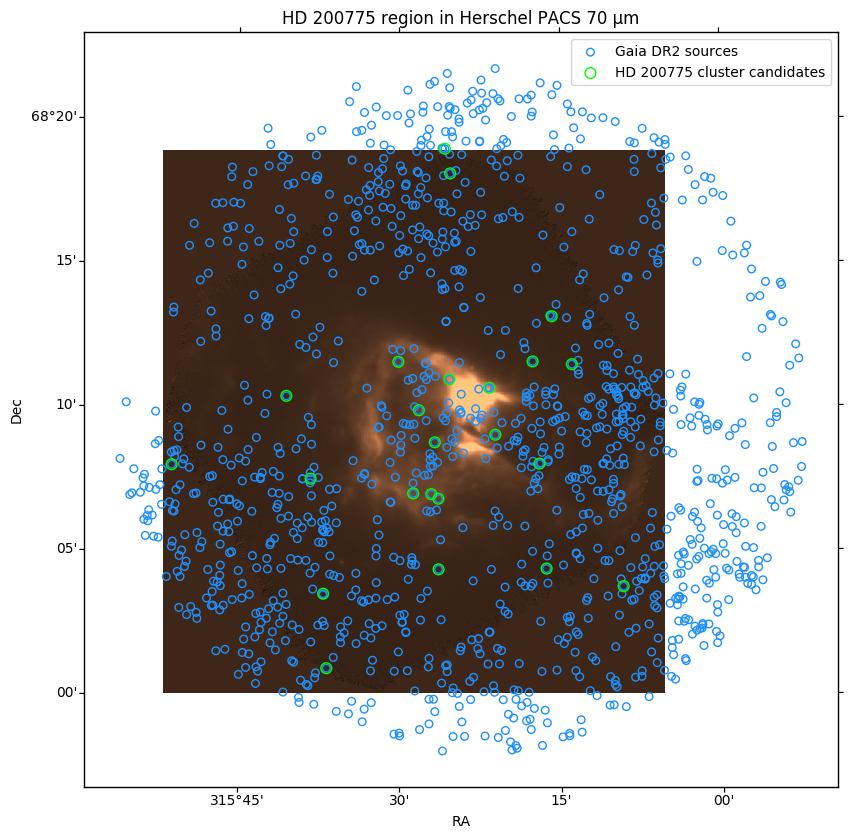

In [18]:
# Overlaying the Gaia sources on the Herschel image
her_image = her_hdu['image'].data

norm = ImageNormalize(her_hdu['image'], interval = ManualInterval(-0.05,0.2)) #play round with the ManualInterval numbers to change the image contrast

fig = plt.figure(figsize=(10,10),dpi=100)    
wcs_h = WCS(her_hdu['image'].header)
ax = fig.add_subplot(111,projection=wcs_h)
ax.set_title("HD 200775 region in Herschel PACS 70 µm")
ax.imshow(her_image,cmap=plt.cm.copper,origin='lower',interpolation='nearest', norm=norm)
p1 = ax.scatter(g['ra'],g['dec'],transform=ax.get_transform('world'), \
               s=30, edgecolor='#1E90FF', facecolor='none', label='Gaia DR2 sources')
p2 = ax.scatter(candidates['ra'],candidates['dec'],transform=ax.get_transform('world'), \
               s=60, edgecolor='#00ff00', facecolor='none', label='HD 200775 cluster candidates')
ax.set_xlabel("RA")
ax.set_ylabel("Dec")
ax.legend(["Gaia DR2 sources","HD 200775 cluster candidates"])


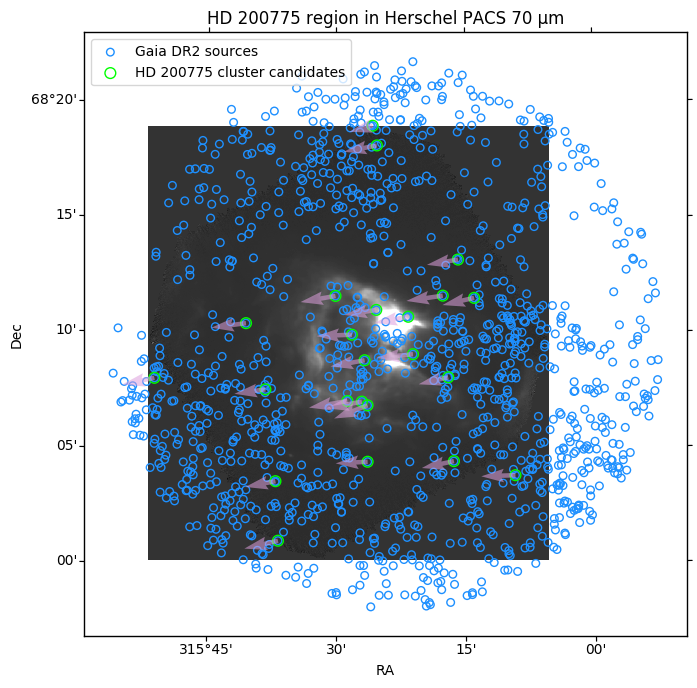

In [19]:
# Overlaying the Gaia sources, cluster candidates and their proper motions on the Herschel image
her_image = her_hdu['image'].data

norm = ImageNormalize(her_hdu['image'], interval = ManualInterval(-0.05,0.2)) #play round with the ManualInterval numbers to change the image contrast

wcs_h = WCS(her_hdu['image'].header)
fig = plt.figure(figsize=(8,8),dpi=100)
ax = fig.add_subplot(111,projection=wcs_h)
ax.set_title("HD 200775 region in Herschel PACS 70 µm")
ax.imshow(her_image,cmap=plt.cm.gray,origin='lower',interpolation='nearest', norm=norm)
p1 = ax.scatter(g['ra'],g['dec'],transform=ax.get_transform('world'), \
               s=30, edgecolor='#1E90FF', facecolor='none', label='Gaia DR2 sources')
p2 = ax.scatter(candidates['ra'],candidates['dec'],transform=ax.get_transform('world'), \
               s=60, edgecolor='#00ff00', facecolor='none', label='HD 200775 cluster candidates')
Q = ax.quiver(candidates['ra'],candidates['dec'],-(candidates['pmra']),candidates['pmdec'],transform=ax.get_transform('world'),color='plum',alpha=0.55) # Define the X-Y axis (ra,dec) and the arrow direction (pmra,pmdec)
ax.set_xlabel("RA")
ax.set_ylabel("Dec")
ax.legend(["Gaia DR2 sources","HD 200775 cluster candidates"])


### Step 5. Visualise the results in pyESASky

In [20]:
esasky = ESASkyWidget()
esasky

ESASkyWidget(layout=Layout(align_self='stretch', height='400px'))

In [21]:
# Go to HD 200775
esasky.goToTargetName('HD 200775')

In [22]:
# Zoom to 15 arcminutes
esasky.setFoV(0.5)

In [23]:
# Set the background HiPS to Herschel PACS colour:
esasky.setHiPS("Herschel", "http://cdn.skies.esac.esa.int/Herschel/PACS-color/")
# Set the background HiPS to 2MASS colour:
#esasky.setHiPS("2MASS", "http://cdn.skies.esac.esa.int/2MASSColor/")
# Set the background HiPS to AllWISE colour:
#esasky.setHiPS("AllWISE", "http://cdn.skies.esac.esa.int/AllWISEColor/")
# Set the background HiPS to Spitzer colour:
#esasky.setHiPS("Spitzer", "http://cdn.skies.esac.esa.int/Spitzer/IRAC134_RGB_bright/")

hipsURL http://cdn.skies.esac.esa.int/Herschel/PACS-color/
imgFormat jpeg


In [24]:
#Overlay the Gaia DR2 cluster candidate sources

# overlayCatalogueFromAstropyTable('<catName>', '<cooFrame>', <HTMLcolor>, '<(astropy.table)>', '<RAColumn>', '<DecColumn>', '<nameColumn>')
# where:
# - <catName> : name of the catalogue that will be used in pyESASky as label
# - <cooFRAME> : coordinate frame
# - <HTMLcolor> : HTML color. It could be a "Color name", "Hex color code" or "RGB color code"
# - <lineWidth> : width used to draw sources. From 1 to 10
# - <idColumn> : name of the column containing a unique identifier for sources if any. None if not applicable
# - <nameColumn> : name of the column with the name of the source
# - <RAColumn> : name of the RA column in degrees
# - <DecColumn> : name of the Dec column in degrees

esasky.overlayCatalogueFromAstropyTable('Candidates', 'J2000', '#00ff00', 5, candidates, '','','')

All the normal ESASky functionality is available in the pyESASky widget. Select the catalogues icon and 
Gaia DR2 to plot all Gaia DR2 sources in the field of view. Change the shape and increase the size of the sources via selecting the colour icon in the results tab. 